In [2]:
import numpy as np
import matplotlib.pyplot as plt

# import verify_gradients as vg
import visualize_clf as vclf
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier as DT, plot_tree

import seaborn as sns

## Preliminary: Data Loading

In [3]:
def load_data(filename) -> np.ndarray:
    with open(f'data/{filename}') as file:
        data = pd.read_csv(file, index_col=0)
        return data

train = load_data('train_prepared.csv')
test = load_data('test_prepared.csv')

# TODO: Make sure we don't need to add the blood_type column

## Part 1: Basic model selection with kNN

### Visualization and basic analysis (Q1)

C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


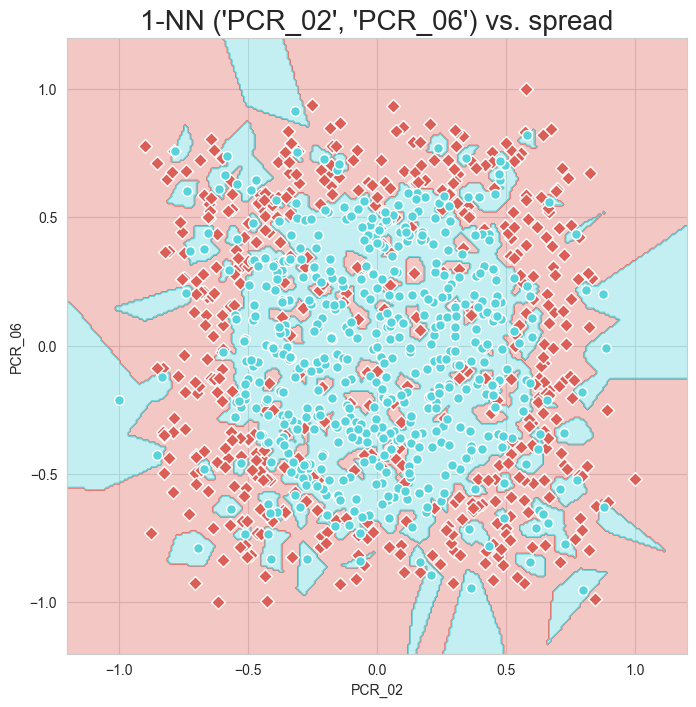

train score: 1.0
test score:  0.648


In [4]:
p1_feats = ('PCR_02', 'PCR_06')

p1_train = train[list(p1_feats)]
p1_test = test[list(p1_feats)]

# learn the training data
decision_tree = kNN(n_neighbors= 1, metric='euclidean')
decision_tree.fit(p1_train, train['spread'])

vclf.visualize_clf(decision_tree, p1_train, train['spread'], f'1-NN {p1_feats} vs. spread', *p1_feats)

print(f"train score: {decision_tree.score(p1_train, train['spread'])}")
print(f"test score:  {decision_tree.score(p1_test, test['spread'])}")

### Model selection

#### (Q2)

In [8]:
ks = list(range(1, 20, 2)) + list(range(20, 695, 65))
results = dict()

for k in ks:
    scores = cross_validate(kNN(k), p1_train, train['spread'], cv=8, return_train_score=True)
    results[k] = {
        'valid_mean': np.mean(scores['test_score']),
        'valid_std': np.std(scores['test_score']),
        'train_mean': np.mean(scores['train_score']),
        'train_std': np.std(scores['train_score'])
    }

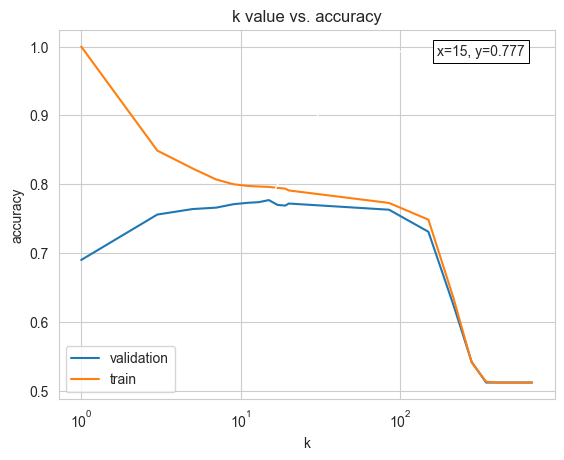

In [6]:
# plot and find best k

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
    return xmax

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(ks, [results[k]['valid_mean'] for k in ks], label='validation')
ax.semilogx(ks, [results[k]['train_mean'] for k in ks], label='train')
ax.legend()
ax.grid(True)
ax.set_xlabel('k')
ax.set_ylabel('accuracy')
ax.set_title('k value vs. accuracy')

best_k = annot_max(ks, np.array([results[k]['valid_mean'] for k in ks]))
plt.show()

#### (Q3)

C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


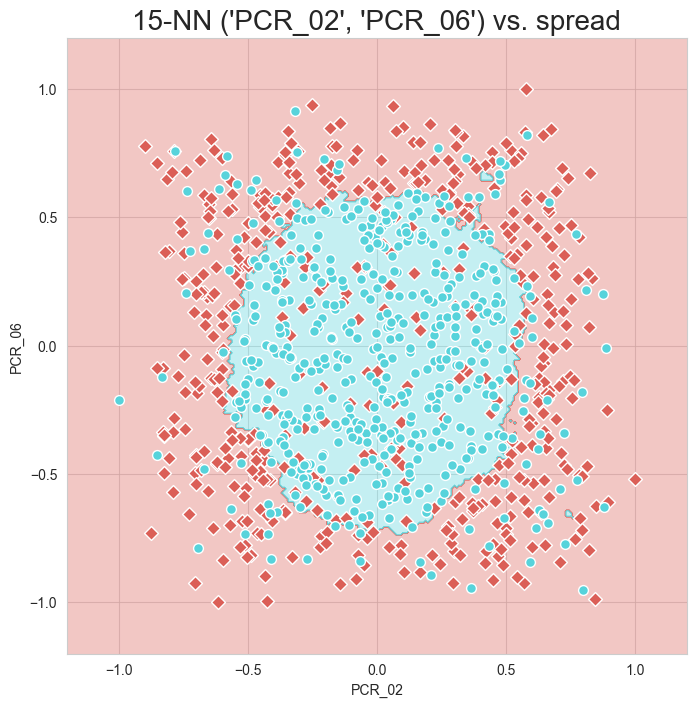

train accuracy: 0.798
test accuracy:  0.732


In [7]:
# learn the training data
decision_tree = kNN(n_neighbors=best_k, metric='euclidean')
decision_tree.fit(p1_train, train['spread'])

vclf.visualize_clf(decision_tree, p1_train, train['spread'], f'{best_k}-NN {p1_feats} vs. spread', *p1_feats)

print(f"train accuracy: {decision_tree.score(p1_train, train['spread'])}")
print(f"test accuracy:  {decision_tree.score(p1_test, test['spread'])}")

#### (Q4) - in docs

## Part 2: Decision trees

### Visualization

#### (Q5)

train accuracy: 0.518
test accuracy: 0.484


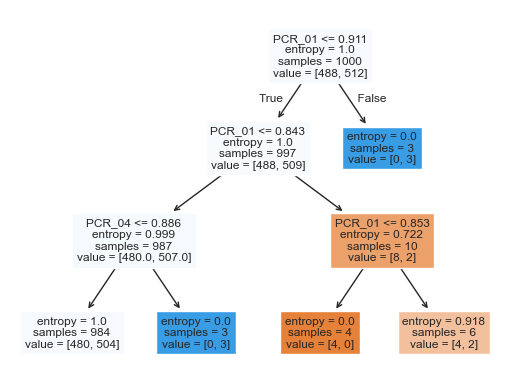

In [5]:
p2_feats = ('PCR_01', 'PCR_04', 'SpecialProperty')

p2_train = train[list(p2_feats)]
p2_test = test[list(p2_feats)]

# learn the training data
decision_tree = DT(criterion='entropy', max_depth=3)
decision_tree.fit(p2_train, train['spread'])

plot_tree(decision_tree, feature_names=p2_feats, max_depth=3, filled=True)

print(f"train accuracy: {decision_tree.score(p2_train, train['spread'])}")
print(f"test accuracy: {decision_tree.score(p2_test, test['spread'])}")

### Model selection

#### (Q6)

In [9]:
# learn the training data
min_samples_leaf_range = range(1, 26, 1)
max_depth_range = range(1, 26, 1)

hyperparameters = {
    'max_depth': max_depth_range,
    'min_samples_leaf': min_samples_leaf_range,
    'criterion': ['entropy']
}

grid_search = GridSearchCV(
    DT(),
    scoring='accuracy',
    param_grid=hyperparameters,
    return_train_score=True,
    cv=5
)
grid_search.fit(p2_train, train['risk'])
res = pd.DataFrame(grid_search.cv_results_)

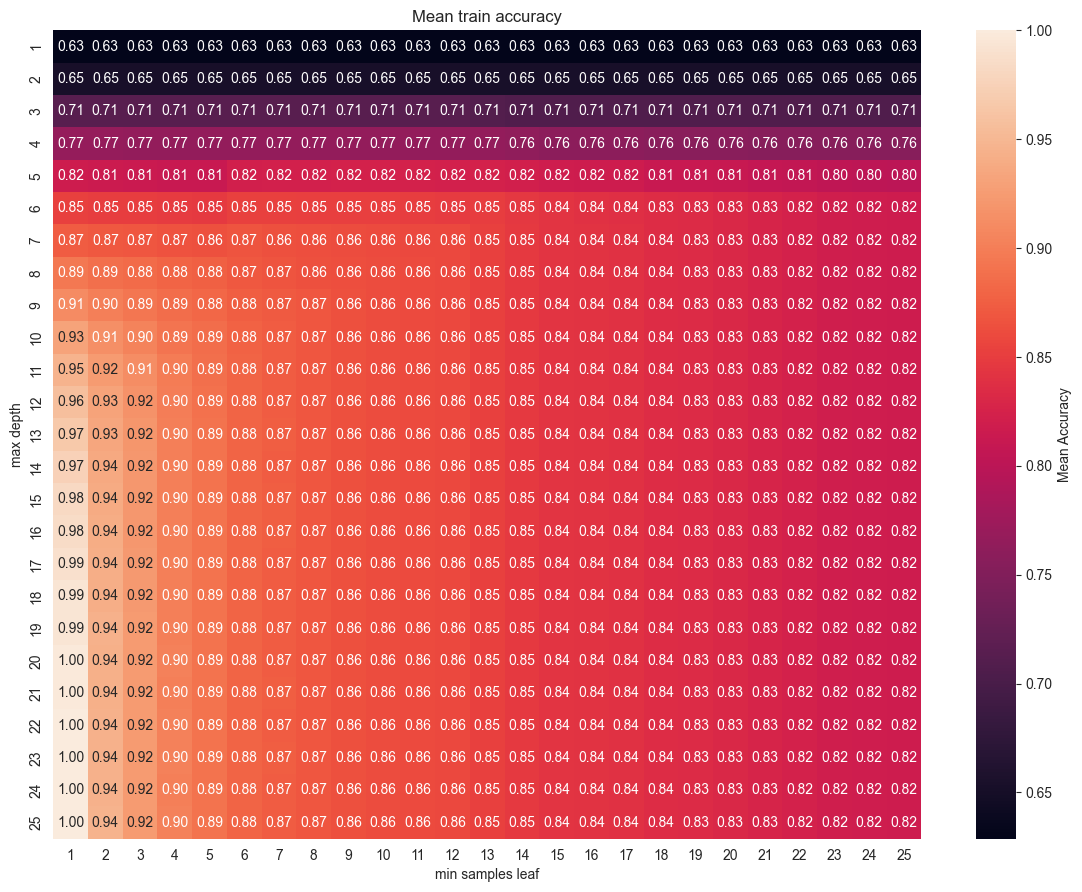

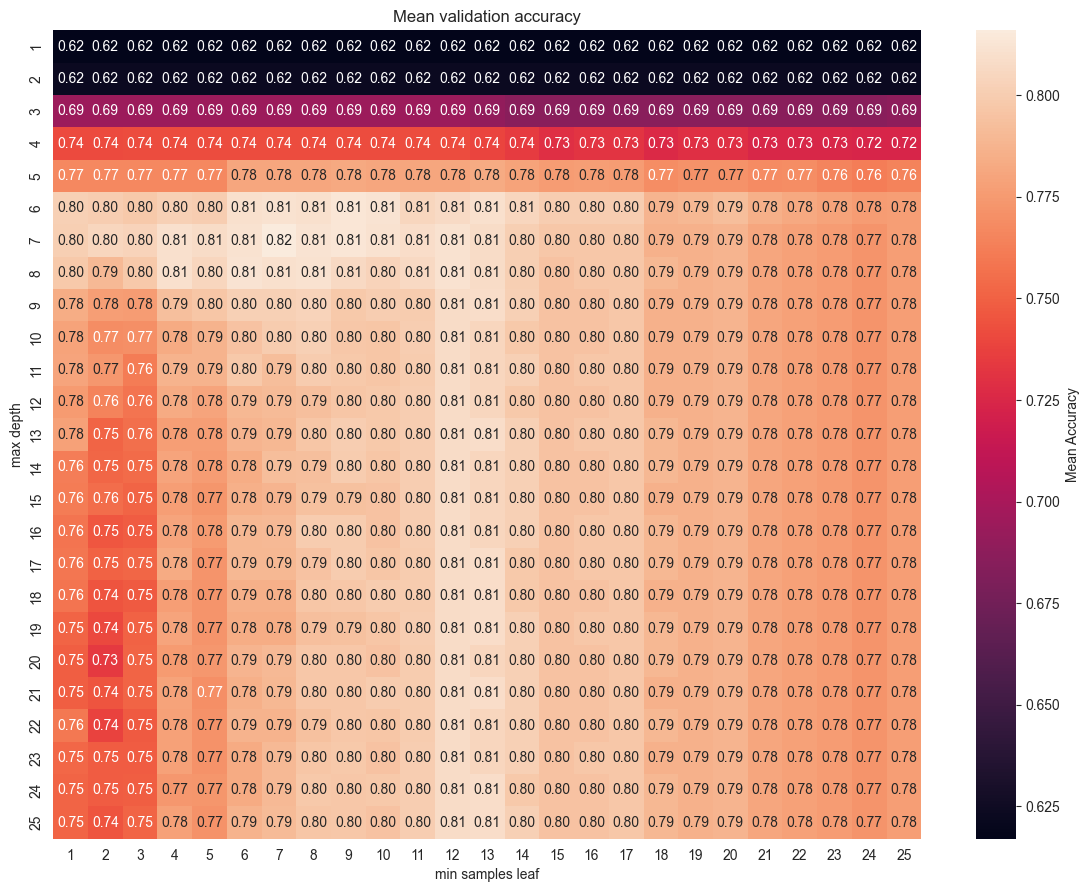

In [10]:
# Train heatmap
heatmap_data_train = res.pivot(
    index='param_max_depth',
    columns='param_min_samples_leaf',
    values='mean_train_score'
)

plt.figure(figsize=(14, 10.5))
sns.heatmap(heatmap_data_train, annot=True, fmt=".2f", cbar_kws={'label': 'Mean Accuracy'})
plt.title("Mean train accuracy")
plt.xlabel("min samples leaf")
plt.ylabel("max depth")
plt.show()


# Validation heatmap
heatmap_data_validation = res.pivot(
    index='param_max_depth',
    columns='param_min_samples_leaf',
    values='mean_test_score'
)

plt.figure(figsize=(14, 10.5))
sns.heatmap(heatmap_data_validation, annot=True, fmt=".2f", cbar_kws={'label': 'Mean Accuracy'})
plt.title("Mean validation accuracy")
plt.xlabel("min samples leaf")
plt.ylabel("max depth")
plt.show()

#### (Q7) - docs

#### (Q8)

In [6]:
max_depth_opt = 7
min_samples_leaf_opt = 7

# learn the training data
decision_tree = DT(criterion='entropy', max_depth=max_depth_opt, min_samples_leaf=min_samples_leaf_opt)
decision_tree.fit(p2_train, train['risk'])

print(f"train accuracy: {decision_tree.score(p2_train, train['risk'])}")
print(f"test accuracy: {decision_tree.score(p2_test, test['risk'])}")

train accuracy: 0.868
test accuracy: 0.824


## Part 3: Linear SVM and the Polynomial kernel

### Implementation of the loss and its gradient

In [127]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5, batch_size = 32):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = batch_size
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = np.array(np.matmul(X, w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, np.array(y).reshape(-1, 1))

        norm = np.dot(w, w)

        maximum = np.maximum(0, 1 - hinge_inputs)
        loss = norm + C * np.sum(maximum)
        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        margins = np.array(np.matmul(X, w) + b).reshape(-1, 1)
        hinge_inputs = margins * y.reshape(-1, 1)

        applied_f = np.where(hinge_inputs < 1, -1, 0).reshape(-1, 1)

        s = np.sum(applied_f * y.reshape(-1, 1) * X, axis=0)
        g_w = 2*w + C * s
        g_b = C * np.sum(applied_f * y)
        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        permutation = np.random.permutation(len(y))
        X = X[permutation, :]
        y = y[permutation]

        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx:end_idx, :]
            batch_y = y[start_idx:end_idx]

            g_w, g_b = self.subgradient(self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step
            self.w -= self.lr * g_w
            self.b -= self.lr * g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
                 NOTE: the labels must be either +1 or -1
        """
        y_pred = np.sign(X @ self.w + self.b)

        return y_pred

def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b

def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()

#### (Q9)

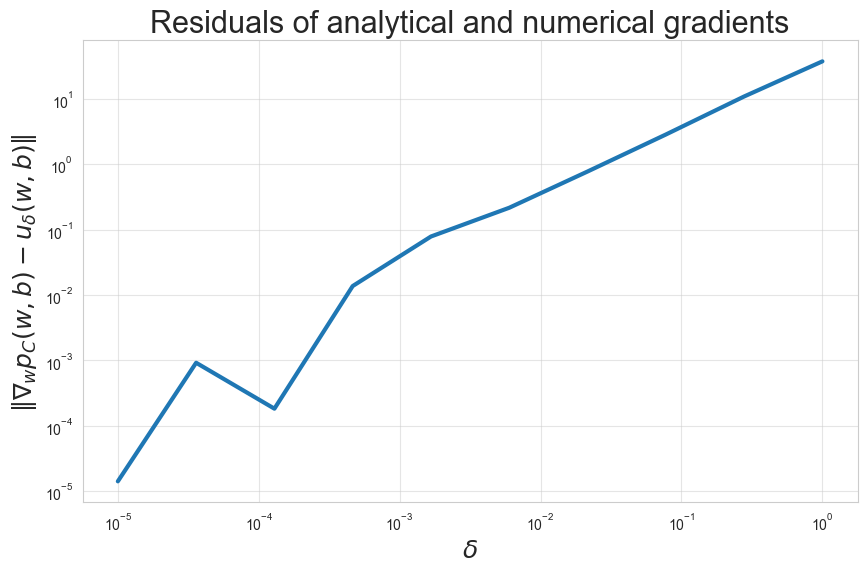

In [128]:
p3_feats = ('PCR_02', 'PCR_06')
p3_target = 'spread'

p3_train = train[list(p3_feats)]
p3_test = test[list(p3_feats)]

compare_gradients(p3_train, train[p3_target].to_numpy(), deltas=np.logspace(-5, 0, 10), REPEATS=100)

### Solving Soft SVM problems using Stochastic Gradient Descent (SGD)

#### (Q10) - docs

#### Task - pre Q11

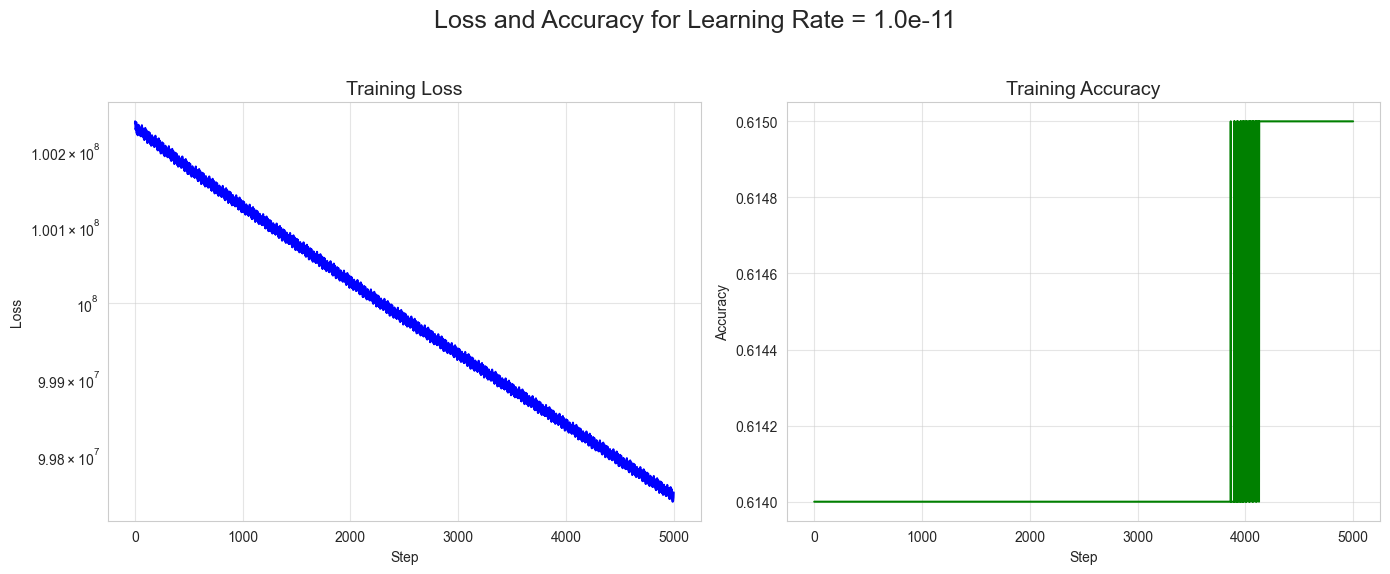

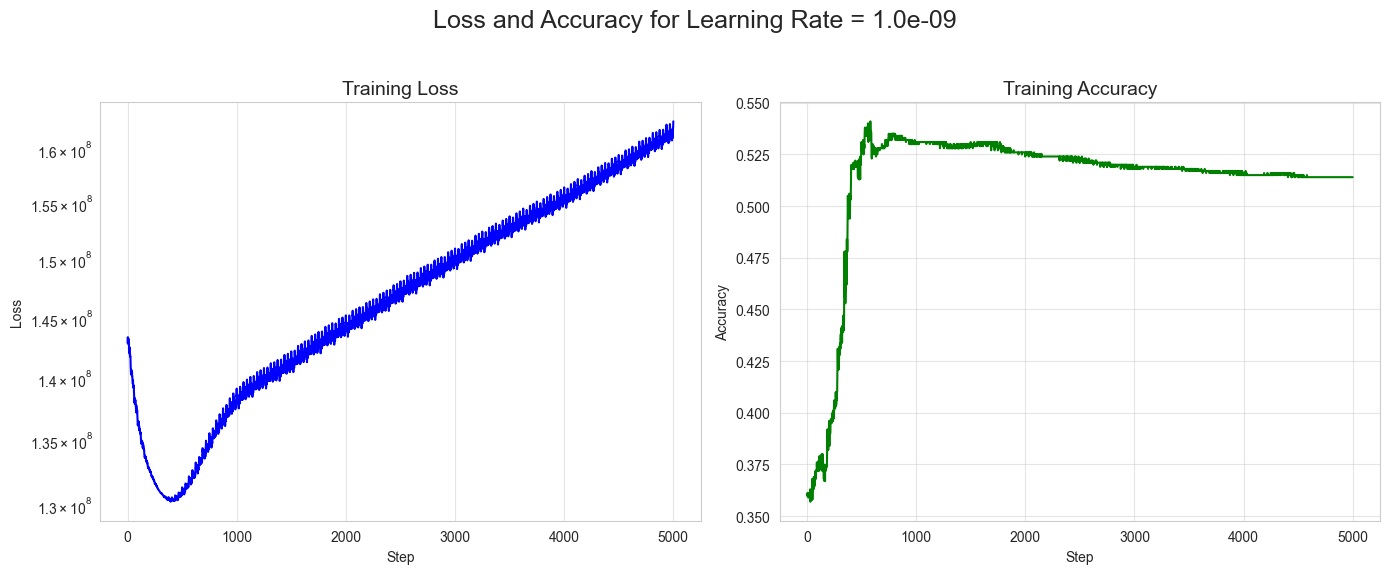

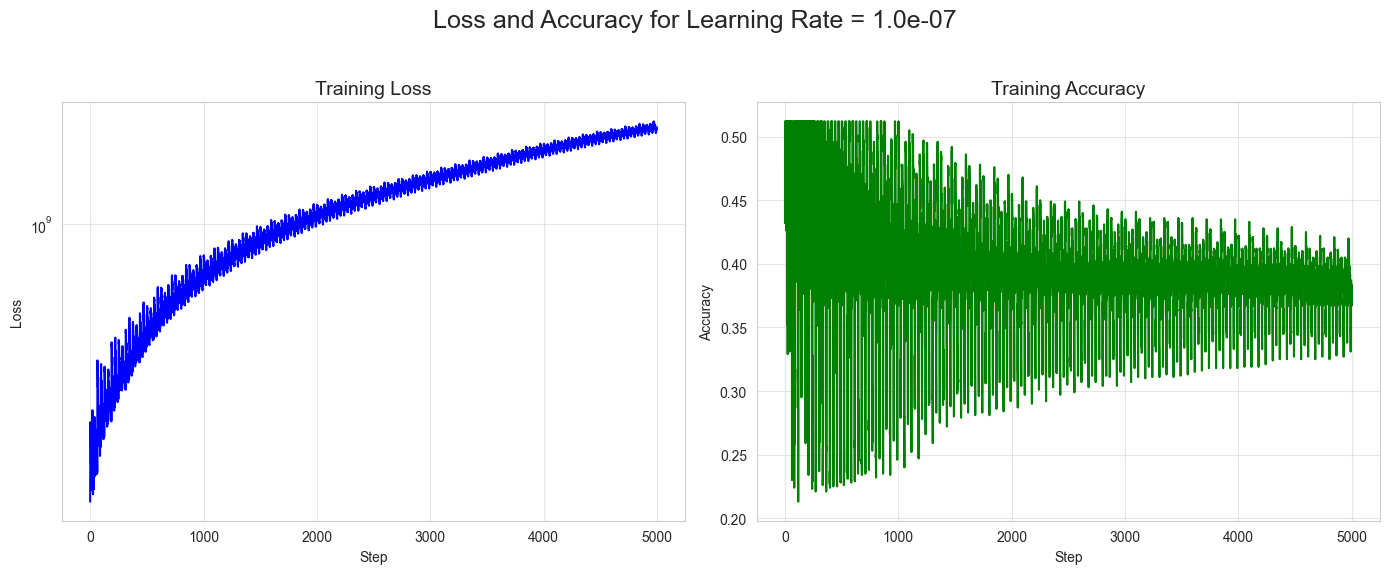

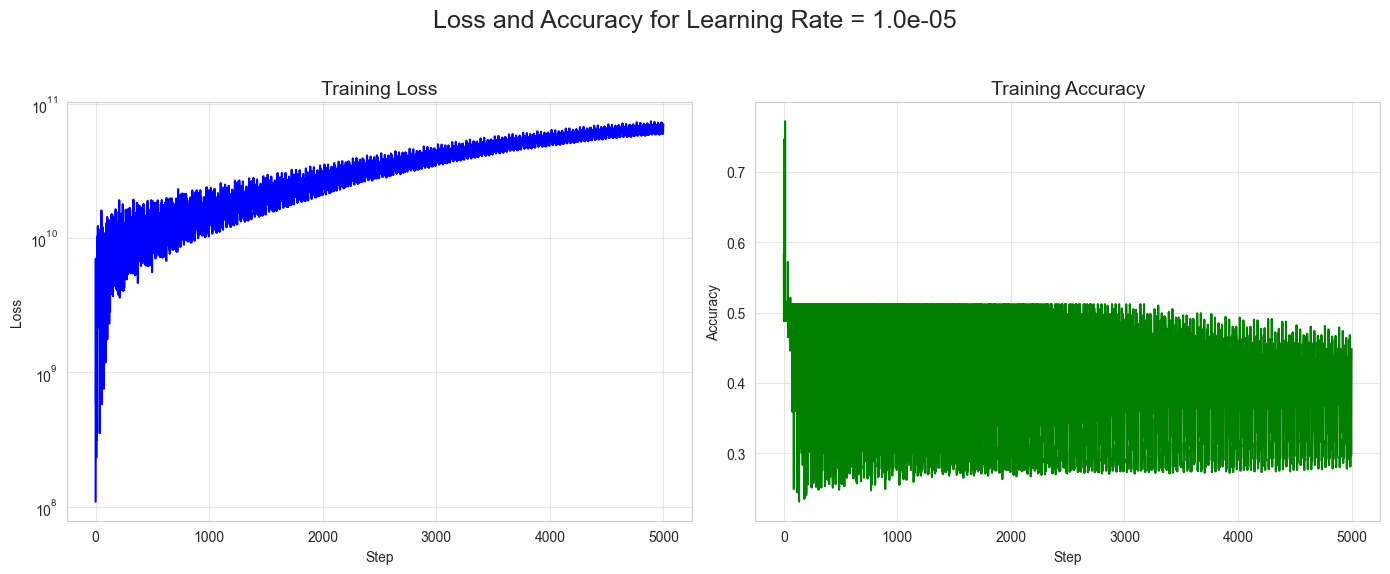

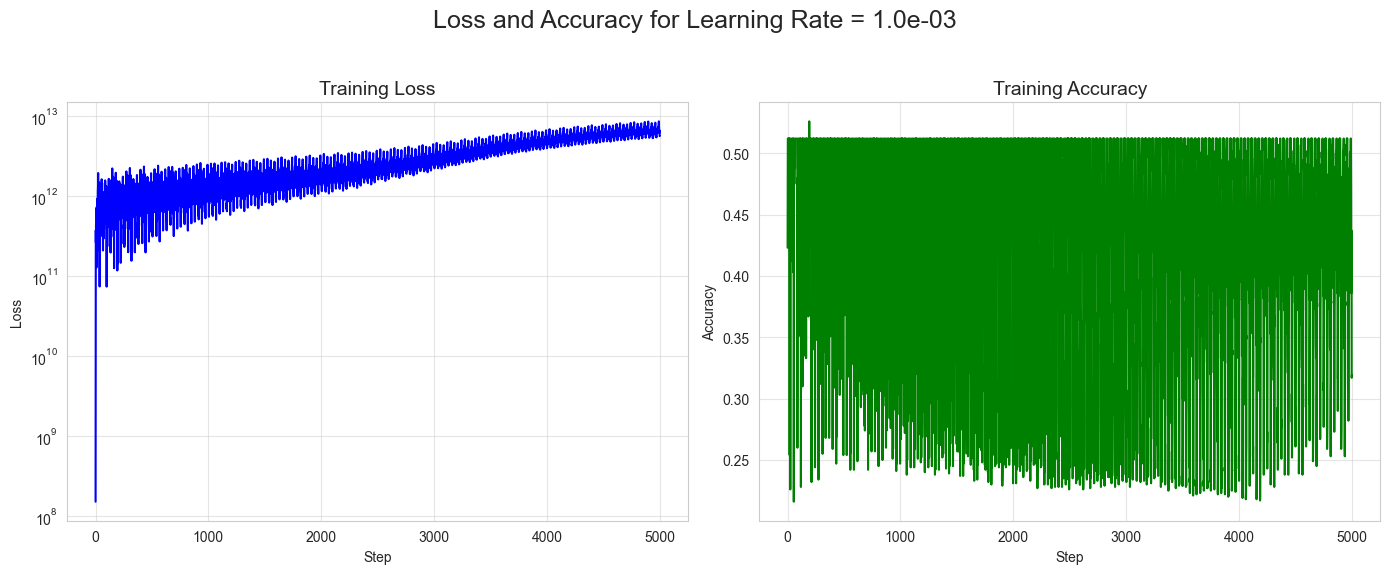

In [163]:
C = 1e5

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

X_train_poly = PolynomialFeatures(degree=3,).fit_transform(p3_train)
X_train_poly = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_train_poly)

for lr in np.logspace(-11, -3, 5):
    clf = SoftSVM(C=C, lr=lr)
    losses, accuracies = clf.fit_with_logs(X_train_poly, train[p3_target].to_numpy(), max_iter=5000)

    # plot
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Subplots with shared layout
    fig.suptitle(f'Loss and Accuracy for Learning Rate = {lr:.1e}', fontsize=18)

    # Loss plot
    axs[0].semilogy(losses, color='blue')
    axs[0].set_title("Training Loss", fontsize=14)
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Loss")
    axs[0].grid(alpha=0.5)

    # Accuracy plot
    axs[1].plot(accuracies, color='green')
    axs[1].set_title("Training Accuracy", fontsize=14)
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(alpha=0.5)

    # Adjust layout
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for suptitle
    plt.show()

#### (Q12)

C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


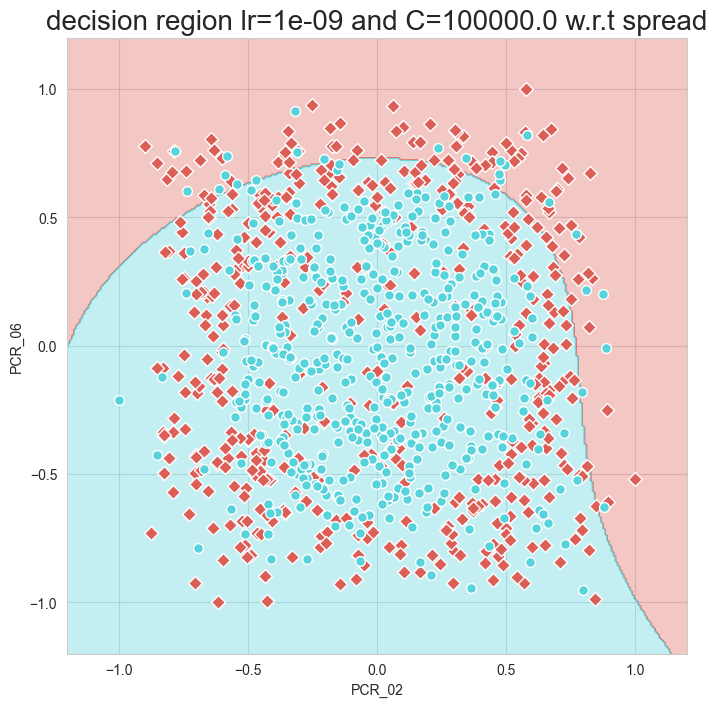

train accuracy: 0.565


C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [165]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

best_lr = 1e-9
C = 1e5

svm_clf = Pipeline([
    ('feature_mapping', PolynomialFeatures(degree=3,)),
    ('scaler', MinMaxScaler()),
    ('SVM', SoftSVM(C=C, lr=best_lr))
])
svm_clf.fit(p3_train, train[p3_target].to_numpy())


vclf.visualize_clf(svm_clf, p3_train, train[p3_target], f'decision region lr={best_lr} and C={C} w.r.t {p3_target}', *p3_train)

print(f'train accuracy: {svm_clf.score(p3_train, train[p3_target])}')
print(f'test accuracy: {svm_clf.score(p3_test, test[p3_target])}')